# 0. Download SRRL DATA

Typical workflow: go to https://midcdmz.nrel.gov/apps/day.pl?BMS 

Get the following fields for ALL TIMES (not just sunrise):

- Global CMP22 (vent/cor) [W/m^2]
- Direct CHP1-1 [W/m^2]
- Diffuse 8-48 (vent) [W/m^2]
- Tower Dry Bulb Temp [deg C]
- Avg Wind Speed @ 6ft [m/s]
- Albedo (CMP11)

Average to 1, 15 or 60 minutes and removes values out of bound (if any)

Save on PSM3 format for use with bifacialVF, SAM, and PVSyst

In [1]:
weatherfolder = 'WeatherFiles'

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import pvlib
import datetime
import pprint
import os

In [3]:
plt.rcParams['timezone'] = 'Etc/GMT+7'
pd.plotting.register_matplotlib_converters()

In [4]:
# This information helps with debugging and getting support :)
import sys, platform
print("Working on a ", platform.system(), platform.release())
print("Python version ", sys.version)
print("Pandas version ", pd.__version__)


Working on a  Windows 10
Python version  3.11.4 | packaged by Anaconda, Inc. | (main, Jul  5 2023, 13:38:37) [MSC v.1916 64 bit (AMD64)]
Pandas version  2.1.0


# Functions to Update SSRL Data and Save

In [5]:
def updateSRRL(srrlfile='bifacial_MIDC_2023.txt', interval='1T', start=None, end=None):
    '''
    updateSRRL(srrlfile)
    
    keep the file in the RTC analysis folder updated with current 1-minute SRRL data
    default file: bifacial_MIDC_2023.txt
    
    start: optional startdate YYYYMMDD to manually override
    end:   optional enddate YYYYMMDD to manually override

    ## SRRL API - limited to 211 days. Described here: https://midcdmz.nrel.gov/apps/data_api_doc.pl?BMS
    # https://midc.nrel.gov/apps/data_api.pl?site=SSSSSSSS&begin=YYYYMMDD&end=YYYYMMDD
    # NOTE:  this downloads EVERYTHING - and takes forever.  
    # NOTE2:  SRRL changed data format in 2020. you need to query 2019 and 2020 data in SEPARATE queries 
    '''
    
    from datetime import datetime
    import pandas as pd

    try:
        srrldata = pd.read_csv(srrlfile, index_col =0)
        srrldata.set_index(pd.to_datetime(srrldata.index), inplace=True)
        if start is None:
            start = pd.to_datetime(srrldata.index[-1]).strftime('%Y%m%d')  # start at the most recent data point in the file
    except FileNotFoundError: # file doesn't exist yet - start from scratch
            # default startdate = 1/1/2019 if the file can't be read
        if start is None:
            start = pd.to_datetime('2023-08-28').strftime('%Y%m%d')
        srrldata = pd.DataFrame()

    if end is None:
        end = pd.to_datetime(datetime.now()).strftime('%Y%m%d')  # today
    
    # if interval == '1T': # SIL Temporary fix because format changed after this...
    #     end = '20191231'
        
    if (pd.to_datetime(end) - pd.to_datetime(start)).days < 200:
        
        newdata = _getSRRL(start,end)
    else: # just get the maximum increment of 200 days
        end = (pd.to_datetime(start)+pd.to_timedelta('200d')).strftime('%Y%m%d') 
        newdata = _getSRRL(start,end)
        
    srrldata = _averageSRRL(srrldata, interval)
    newdata15 = _averageSRRL(newdata, interval) # 15-minute averaged, raw
    
    # combine with existing srrldata
    
    combined = pd.concat([srrldata,newdata15],sort=True) #.drop_duplicates()
    #de-dupe the data
    combined = combined.loc[~combined.index.duplicated(keep='first')]
    
    print('Saving to file: {}'.format(srrlfile))
    combined.to_csv(srrlfile)
    return combined    
    
    
def _getSRRL(start,end):
    '''
    getSRRL(start,end)
    
    API function to call SRRL BMS data
    start, end:  YYYYMMDD format
    
    returns:  dataframe
    
    '''
    import io
    import pandas as pd
    import requests
    
    
    site = 'BMS'
    paramlist = ['Global CMP22 (vent/cor) [W/m^2]',
             'Direct CHP1-1 [W/m^2]',
             'Diffuse 8-48 (vent) [W/m^2]',
             'Tower Dry Bulb Temp [deg C]',
             'Avg Wind Speed @ 6ft [m/s]',
             'Albedo (CMP11)'
            ]

    url="https://midcdmz.nrel.gov/apps/data_api.pl?site={}&begin={}&end={}".format(site,start,end)
    s=requests.get(url).content
    df=pd.read_csv(io.StringIO(s.decode('utf-8')))
    # change Year, DOY and MST into datetime index
    date = pd.to_datetime(df.Year, format='%Y') + pd.to_timedelta(df.DOY - 1, unit='d') 
    time = pd.to_datetime(df['MST'].apply('{:0>4}'.format),format='%H%M') #Sil is this df['MST']? ORigina lsayd "c['MST']"
    df['date'] = date 
    df['time'] = time
    df['datetime'] = pd.to_datetime({'Year':date.dt.year, 'Month':date.dt.month, 'Day':date.dt.day, 'Hour':time.dt.hour, 'Minute':time.dt.minute})
    df = df.set_index(pd.DatetimeIndex(df.datetime))
    
    return df[paramlist]

def _averageSRRL(df, interval='15T', closed='right', label='right'):
    try:
        df = df.resample(interval, closed=closed, label=label).mean() #
    except:
        print('Warning - unable to average')
    return df

def cleanSRRL(df):
    #function to  remove <0 data
    # set all fields except 'Tower Dry Bulb Temp [deg C]' >=0
    tamb = df['Tower Dry Bulb Temp [deg C]'].copy()
    df[df < 0] = 0
    df['Tower Dry Bulb Temp [deg C]'] = tamb
    return df


In [6]:
# https://stackoverflow.com/questions/34966422/remove-leap-year-day-from-pandas-dataframe/34966636
def is_leap_and_29Feb(s):
    return (s.index.year % 4 == 0) & \
           ((s.index.year % 100 != 0) | (s.index.year % 400 == 0)) & \
           (s.index.month == 2) & (s.index.day == 29)

## DOWNLOAD DATA

In [7]:
srrlfile = os.path.join(weatherfolder,'bifacial_MIDC_2023.txt')
interval = '1T'
start = pd.to_datetime('2023-08-28').strftime('%Y%m%d')
end = None # up to current data, or as far as it can get; if too many days have to run _getSRRl a couple times.

weatherdata = updateSRRL(srrlfile)
weatherdata = cleanSRRL(weatherdata)
weatherdata['Albedo (CMP11)'] = weatherdata['Albedo (CMP11)'].clip(0.0,1.0)


Warning - unable to average
Saving to file: WeatherFiles\bifacial_MIDC_2023.txt


## LOAD Data

In [8]:
def saveSAM_SRRLWeatherFile(srrl15, savefile='BARN_SamFile.csv', includeminute = True):
    """
    Saves a dataframe with weather data from SRRL on SAM-friendly format.

    INPUT:
    data
    savefile
    includeminute  -- especially for hourly data, if SAM input does not have Minutes, it assuems it's TMY3 format and 
                      calculates the sun position 30 minutes prior to the hour (i.e. 12 timestamp means sun position at 11:30)
                      If minutes are included, it will calculate the sun position at the time of the timestamp (12:00 at 12:00)
                      Include minutes if resolution of data is not hourly duh. (but it will calculate at the timestamp)
                      
    Headers expected by SAM:
    ************************* 
    # Source	Location ID	City	State	Country	Latitude	Longitude	Time Zone	Elevation		

    Column names
    *************
    # Year	Month	Day	Hour	Minute	Wspd	Tdry	DHI	DNI	GHI	Albedo

    OR
    # Year	Month	Day	Hour	Wspd	Tdry	DHI	DNI	GHI	Albedo

    """

    import pandas as pd

    header = "Source,Location ID,City,State,Country,Latitude,Longitude,Time Zone,Elevation,,,,,,,,,,\n" + \
            "Measured,724666,DENVER/CENTENNIAL [GOLDEN - NREL],CO,USA,39.742,-105.179,-7,1829,,,,,,,,,,\n"

    if includeminute:
        savedata = pd.DataFrame({'Year':srrl15.index.year, 'Month':srrl15.index.month, 'Day':srrl15.index.day,
                                 'Hour':srrl15.index.hour, 'Minute':srrl15.index.minute,
                                 'Wspd':srrl15['Avg Wind Speed @ 6ft [m/s]'],
                                 'Tdry':srrl15['Tower Dry Bulb Temp [deg C]'],
                                 'DHI':srrl15['Diffuse 8-48 (vent) [W/m^2]'],
                                 'DNI':srrl15['Direct CHP1-1 [W/m^2]'],
                                 'GHI':srrl15['Global CMP22 (vent/cor) [W/m^2]'],
                                 'Albedo':srrl15['Albedo (CMP11)']
                                 })
    else:
         savedata = pd.DataFrame({'Year':srrl15.index.year, 'Month':srrl15.index.month, 'Day':srrl15.index.day,
                                 'Hour':srrl15.index.hour,
                                 'Wspd':srrl15['Avg Wind Speed @ 6ft [m/s]'],
                                 'Tdry':srrl15['Tower Dry Bulb Temp [deg C]'],
                                 'DHI':srrl15['Diffuse 8-48 (vent) [W/m^2]'],
                                 'DNI':srrl15['Direct CHP1-1 [W/m^2]'],
                                 'GHI':srrl15['Global CMP22 (vent/cor) [W/m^2]'],
                                 'Albedo':srrl15['Albedo (CMP11)']
                                 })
    with open(savefile, 'w', newline='') as ict:
        # Write the header lines, including the index variable for
        # the last one if you're letting Pandas produce that for you.
        # (see above).
        for line in header:
            ict.write(line)

        savedata.to_csv(ict, index=False)


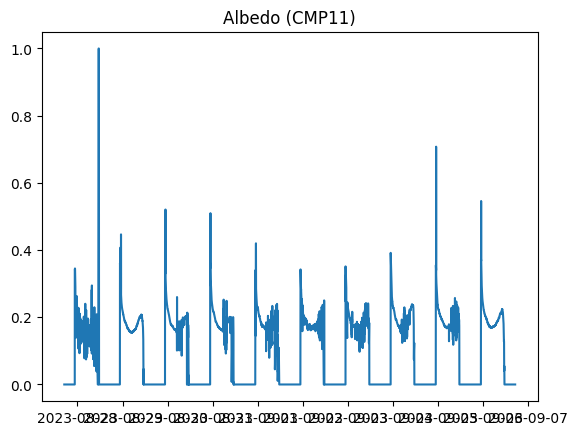

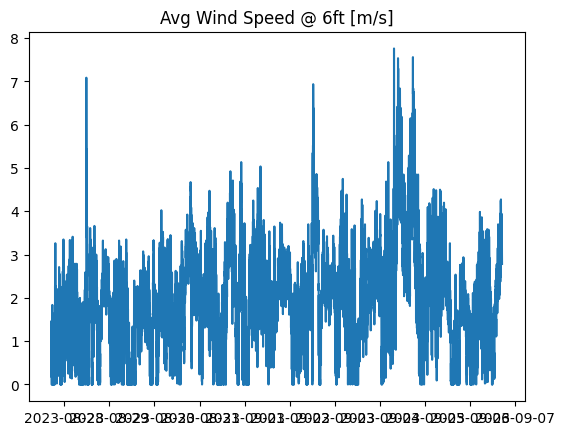

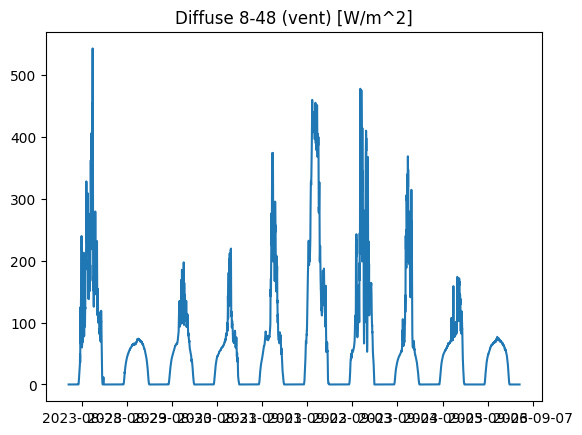

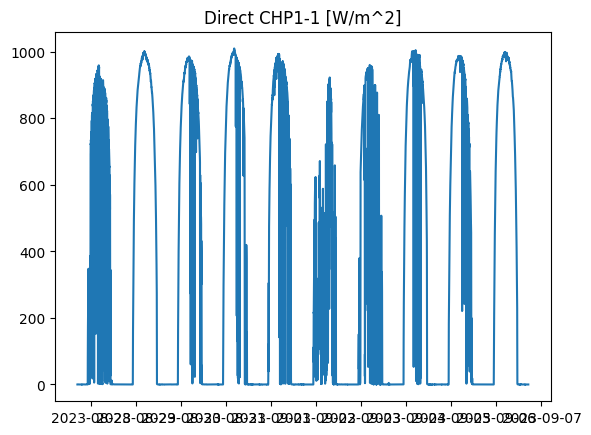

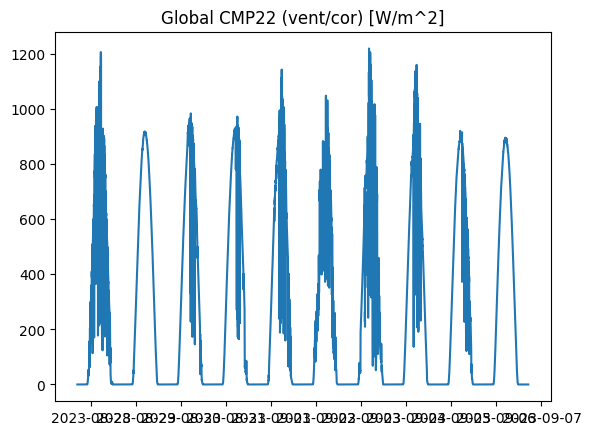

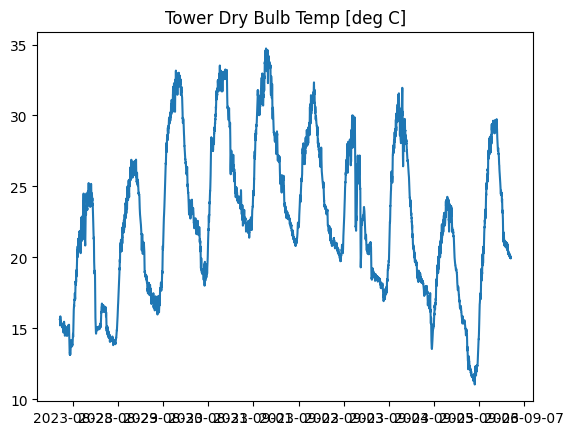

In [9]:
for col in weatherdata:
    plt.figure()
    plt.plot(weatherdata[col])
    plt.title(col)

In [10]:
loc_weatherdata_1T = weatherdata.tz_localize('Etc/GMT+7')

weatherdata_15T = _averageSRRL(loc_weatherdata_1T, interval='15T', closed='right', label='right')
weatherdata_60T = _averageSRRL(loc_weatherdata_1T, interval='60T', closed='right', label='right')



In [11]:
freq='60T'
df = weatherdata_60T.copy()


In [12]:
def fillYear(df, freq):
    import pandas as pd
    # add zeros for the rest of the year
    if freq is None:
        try:
            freq = pd.infer_freq(df.index)
        except:
            freq = '15T'  # 15 minute data by default
    tzinfo = df.index.tzinfo
    starttime = pd.to_datetime('%s-%s-%s %s:%s' % (df.index.year[0],1,1,0,0 ) ).tz_localize(tzinfo)
    endtime = pd.to_datetime('%s-%s-%s %s:%s' % (df.index.year[-1],12,31,23,60-int(freq[:-1])) ).tz_localize(tzinfo)
    beginning = df.index[0]
    ending = df.index[-1]
    df.loc[starttime] = 0  # set first datapt to zero to forward fill w zeros
    df.loc[endtime] = 0    # set last datapt to zero to forward fill w zeros
    df = df.sort_index()
    # add zeroes before data series
    df2= df[0:2].resample(freq).ffill()
    combined = pd.concat([df,df2],sort=True)
    combined = combined.loc[~combined.index.duplicated(keep='first')]
    # add zeroes after data series
    df2  = combined.resample(freq).bfill()
    return df2

In [13]:
TMY = fillYear(weatherdata_60T, freq='60T')

In [14]:
filterdates = (TMY.index >= '2023-1-1') & ~(is_leap_and_29Feb(TMY)) & (TMY.index < '2024-1-1') 
TMY = TMY[filterdates]
TMY

,Albedo (CMP11),Avg Wind Speed @ 6ft [m/s],Diffuse 8-48 (vent) [W/m^2],Direct CHP1-1 [W/m^2],Global CMP22 (vent/cor) [W/m^2],Tower Dry Bulb Temp [deg C]
datetime,,,,,,
2023-01-01 00:00:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 01:00:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 02:00:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 03:00:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0
2023-01-01 04:00:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
2023-12-31 19:00:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 20:00:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0
2023-12-31 21:00:00-07:00,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
saveSAM_SRRLWeatherFile(weatherdata_60T, os.path.join(weatherfolder,'PSM3_60T.csv'), includeminute=False) # No minutes = sunposition T-30min
saveSAM_SRRLWeatherFile(TMY, os.path.join(weatherfolder,'PSM3_TMY.csv'), includeminute=False) # No minutes = sunposition T-30min
saveSAM_SRRLWeatherFile(weatherdata, os.path.join(weatherfolder,'PSM3_1T.csv'), includeminute=False) # No minutes = sunposition T-30min
saveSAM_SRRLWeatherFile(weatherdata_15T, os.path.join(weatherfolder,'PSM3_15T.csv'), includeminute=False) # No minutes = sunposition T-30min